In [149]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer 
  
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/jayiraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/jayiraj/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jayiraj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [150]:
df= pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [151]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [152]:
# Rename the columns
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

df.head()

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [153]:
df['emotions'] = df['emotions'].replace('No emotion toward brand or product', 'Neutral')
df['emotions'] = df['emotions'].replace('Positive emotion', 'Positive')
df['emotions'] = df['emotions'].replace('Negative emotion', 'Negative')

In [154]:
df = df[df['emotions'].isin(['Neutral', 'Negative', 'Positive'])]

In [155]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [51]:
#Map emotions to target values
#label_encoder = LabelEncoder()

# Fitting the encoder to the 'emotions' column and transforming it
#df['target'] = label_encoder.fit_transform(df['emotions'])

# Checking the first few rows to see the result
#df.head()


,tweet_text,products,emotions,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,2


In [156]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [157]:
df.isna().sum()

tweet_text       1
products      5655
emotions         0
dtype: int64

In [158]:
df = df.dropna(subset=['tweet_text'])

In [159]:
df.isna().sum()

tweet_text       0
products      5654
emotions         0
dtype: int64

In [160]:
# Bring in stopwords

sw = stopwords.words('english')

In [161]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [162]:
lemmatizer = WordNetLemmatizer() 

In [163]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: column from database
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

In [164]:
# Create a new column in your DataFrame for the preprocessed text
df['preprocessed_text'] = df['tweet_text'].apply(lambda x: doc_preparer(x))

# Now you can perform EDA on 'preprocessed_text'
# For example, token frequency analysis
from collections import Counter
all_words = ' '.join(df['preprocessed_text']).split()
word_freq = Counter(all_words)
word_freq

Counter({'wesley': 1,
         'g': 79,
         'iphone': 1560,
         'hr': 5,
         'tweet': 169,
         'rise': 12,
         'austin': 959,
         'dead': 18,
         'need': 240,
         'upgrade': 15,
         'plugin': 4,
         'station': 12,
         'sxsw': 9504,
         'jessedee': 1,
         'know': 210,
         'fludapp': 1,
         'awesome': 135,
         'ipad': 2961,
         'app': 821,
         'likely': 13,
         'appreciate': 6,
         'design': 224,
         'also': 77,
         'give': 185,
         'free': 390,
         't': 2,
         'swonderlin': 1,
         'wait': 139,
         'sale': 46,
         'hope': 51,
         'year': 167,
         'festival': 32,
         'crashy': 2,
         'sxtxstate': 9,
         'great': 226,
         'stuff': 35,
         'fri': 7,
         'marissa': 193,
         'mayer': 219,
         'google': 2621,
         'tim': 19,
         'reilly': 9,
         'tech': 166,
         'book': 39,
         'conf

In [165]:
all_words = ' '.join(df['preprocessed_text']).split()

# Compute the frequency distribution
freq_dist = FreqDist(all_words)

# Display the most common words
print(freq_dist.most_common(50))

[('sxsw', 9504), ('mention', 7028), ('link', 4280), ('ipad', 2961), ('rt', 2936), ('google', 2621), ('apple', 2309), ('quot', 1657), ('iphone', 1560), ('store', 1508), ('new', 1087), ('austin', 959), ('amp', 834), ('app', 821), ('launch', 794), ('get', 696), ('circle', 673), ('social', 658), ('pop', 600), ('android', 594), ('today', 576), ('open', 527), ('go', 477), ('network', 474), ('line', 452), ('via', 428), ('party', 402), ('call', 395), ('free', 390), ('mobile', 357), ('come', 347), ('sxswi', 340), ('one', 313), ('win', 312), ('time', 309), ('see', 308), ('check', 305), ('like', 303), ('major', 303), ('use', 294), ('day', 288), ('make', 287), ('map', 273), ('w', 269), ('u', 266), ('temporary', 264), ('need', 240), ('possibly', 240), ('look', 233), ('great', 226)]


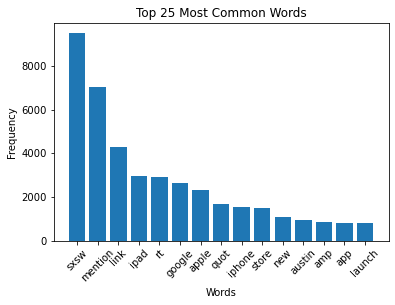

In [166]:
import matplotlib.pyplot as plt

# Get the most common words and their counts
common_words = freq_dist.most_common(15)
words, counts = zip(*common_words)

# Create a bar chart
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 25 Most Common Words')
plt.xticks(rotation=45)
plt.show()

# Splitting our Data

In [167]:
X = df['tweet_text'] 
y = df['emotions'] 

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating Pipelines

In [169]:

#Multinomial Naive Bayes Pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('nb', MultinomialNB())
])

In [188]:
#Random Forest Pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('rf', RandomForestClassifier(random_state = 42, class_weight='balanced'))
])

# Grid Search Set Up

In [171]:
nb_param_grid = {
    'tfidf__max_df': [0.75],
    'tfidf__min_df': [.01,.05,.1],
    'tfidf__ngram_range': [(1, 2)],
}

In [220]:
rf_param_grid = {
    'tfidf__max_df': [.6, .65],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1)],
    'rf__n_estimators': [100, 150], 
    'rf__max_depth': [None, 2, 5],
 'rf__min_samples_split':[3,4],
   'rf__min_samples_leaf':[1,2]}

# Naive Bayes Grid Search

In [174]:
# Calculate class weights
class_weights = compute_sample_weight('balanced', y_train)
# Ensure class_weights has the correct length
class_weights = class_weights[:X_train.shape[0]]

In [175]:
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, n_jobs=1, verbose=2)
nb_grid_search.fit(X_train, y_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   4.1s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   4.0s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   4.0s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   4.1s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   4.0s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   4.0s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   4.1s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7f76e8ada790>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'tfidf__max_df': [0.75],
                         'tfidf__min_df': [0.01, 0.05, 0.1],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=2)

# Random Forest Grid Search

In [221]:
# Grid search with RandomForestClassifier pipeline
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, n_jobs=1, verbose=2)
rf_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total= 2.2min
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   7.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   7.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   7.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.7s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   7.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.8s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   7.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   7.3s
[CV] rf__max_depth=40, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.9s
[CV] rf__max_depth=40, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=40, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   7.9s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   8.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   7.9s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   7.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   7.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   7.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   8.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   8.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.7s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.7s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   7.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.6s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.9s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  r

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__

[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.0s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__max_depth=50, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__ma

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=  14.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=  10.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=  10.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   7.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1)

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.2s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.2s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   9.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   9.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   9.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1)

[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   8.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   8.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   8.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1)

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   7.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   7.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   7.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1)

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=1, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   7.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.6, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 


[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=500, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1)

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=20, tfidf__ngram_range=(1,

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=3, rf__n_estimators=500, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1)

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=100, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 

[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.3s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.4s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1, 1), total=   6.5s
[CV] rf__max_depth=None, rf__min_samples_leaf=3, rf__min_samples_split=5, rf__n_estimators=500, tfidf__max_df=0.4, tfidf__min_df=20, tfidf__ngram_range=(1,

[Parallel(n_jobs=1)]: Done 4374 out of 4374 | elapsed: 370.1min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7f76e8ada790>)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'rf__max_depth': [10, 20, 30, 40, 50, None],
                         'rf__min_samples_leaf': [1, 2, 3],
                         'rf__min_samples_split': [2, 3, 5],
                         'rf__n_estimators': [100, 200, 500],
                         'tfidf__max_df': [0.4, 0.5, 0.6],
                         'tfidf__min_df': [1, 10, 20],
                         'tfidf__ngram_range': [(1, 1)]},
             verbose=2)

# Model Evaluation

In [177]:
# Evaluation for Naive Bayes


nb_best_model = nb_grid_search.best_estimator_
print("Best Parameters for Naive Bayes:", nb_grid_search.best_params_)
print("Grid Search Best Score:", nb_grid_search.best_score_)
#print(classification_report(y_test, y_pred_nb))


Best Parameters for Naive Bayes: {'tfidf__max_df': 0.75, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Grid Search Best Score: 0.6439556245014607


In [222]:
#Evaluation for Random Forest
rf_best_model = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Grid Search Best Score:", rf_grid_search.best_score_)



#print(classification_report(y_test, y_pred_rf))

Best Parameters for Random Forest: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 100, 'tfidf__max_df': 0.6, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Grid Search Best Score: 0.6764131461552636


In [223]:
rf_best_model.score(X_train, y_train)

0.9941242305540011

# Confusion Matrix

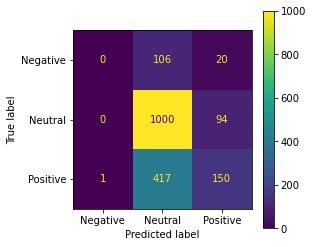

In [184]:
y_pred_nb = nb_best_model.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels= nb_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

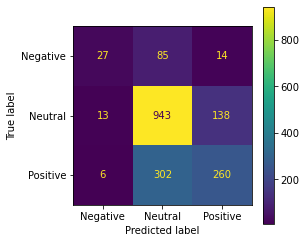

In [218]:
y_pred_rf = rf_best_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= rf_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

## Features importances

In [ ]:
rf_tfidf_vectorizer = rf_pipeline.named_steps['tfidf']
rf_feature_names = rf_tfidf_vectorizer.get_feature_names_out()
rf_tfidf_scores = rf_tfidf_vectorizer.idf_

In [ ]:
rf_model = rf_pipeline.named_steps['rf']
rf_feature_importances = rf_model.feature_importances_

In [ ]:
rf_tfidf_feature_importance = dict(zip(rf_feature_names, rf_tfidf_scores))
sorted_rf_tfidf_importance = sorted(rf_tfidf_feature_importance.items(), key=lambda x: x[1], reverse=True)

# For Random Forest
rf_feature_importance = dict(zip(rf_feature_names, rf_feature_importances))
sorted_rf_importance = sorted(rf_feature_importance.items(), key=lambda x: x[1], reverse=True)

In [ ]:
#pd.DataFrame.sparse.from_spmatrix(X_t_vec, columns=tfidf.get_feature_names_out())

# Model Evaluation on the Test Set

In [ ]:
X_val


X_val_df = pd.DataFrame(X_val_vec.toarray(), columns=tfidf.get_feature_names_out())
final_X_test = pd.concat([
    X_val_df, X_t[["num_sentences", "contains_price", "contains_emoticon"]]
], axis=1)
final_X_test